In [1]:
# region General Imports
import os
import re
import uuid
import shutil
import time
import random
import datetime
import glob
import pickle
import tqdm
import copy
import optuna
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from rich import print as rprint
from rich.pretty import pprint as rpprint
from tqdm import tqdm
from itertools import chain
from functools import partial
# endregion General Imports

import tempfile
import tensorflow as tf
import numpy as np
from tensorflow import keras

import tensorflow_model_optimization as tfmot
%load_ext tensorboard
    
# os.environ["KERAS_BACKEND"] = "tf"
# os.environ["TF_USE_LEGACY_KERAS"] = "0"
# import jax
# import jax.numpy as jnp
# import keras
    
# region Keras
from keras.models import Model
from keras.layers import Dense, Activation, Permute, Dropout
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Conv1D,
    MaxPooling1D,
    AveragePooling1D,
)
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.regularizers import l1_l2
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras import backend as K
# endregion Keras

from custom_datasets.fatigue_mi import FatigueMI

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from sklearn import preprocessing

from model_optim.utils import channels_to_channels_idx

/home/arazzz/anaconda3/envs/moabb_model_optimization_quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-08 01:19:11.709881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 01:19:11.710032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 01:19:11.714196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 01:19:11.736530: I tensorflow/core/platform/cpu_feature_guard

To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


/home/arazzz/anaconda3/envs/moabb_model_optimization_quant/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [2]:
SKLRNG = 42
# RNG = jax.random.PRNGKey(SKLRNG)

In [3]:
# region Helper funcs
def shallow_conv_net_square_layer(x):
    return tf.math.square(x)

def shallow_conv_net_log_layer(x):
    return tf.math.log(tf.clip_by_value(x, 1e-7, 10000))

CUSTOM_OBJECTS = {
    "shallow_conv_net_square_layer": shallow_conv_net_square_layer, 
    "shallow_conv_net_log_layer": shallow_conv_net_log_layer 
}
# endregion Helper funcs

# region Models
def shallow_conv_net(
    nb_classes, channels, samples, **kwargs
):
    """
    From: https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """

    _POOL_SIZE_D2_ = kwargs.get("pool_size_d2", 35)
    _STRIDES_D2_ = kwargs.get("strides_d2", 7)
    _CONV_FILTERS_D2_ = kwargs.get("conv_filters_d2", 13)

    _POOL_SIZE_ = kwargs.get("pool_size", (1, _POOL_SIZE_D2_))
    _STRIDES_ = kwargs.get("strides", (1, _STRIDES_D2_))
    _CONV_FILTERS_ = kwargs.get("conv_filters", (1, _CONV_FILTERS_D2_))

    _CONV2D_1_UNITS_ = kwargs.get("conv2d_1_units", 40)
    _CONV2D_2_UNITS_ = kwargs.get("conv2d_2_units", 40)
    _L2_REG_1_ = kwargs.get("l2_reg_1", 0.01)
    _L2_REG_2_ = kwargs.get("l2_reg_2", 0.01)
    _L2_REG_3_ = kwargs.get("l2_reg_3", 0.01)
    _DROPOUT_RATE_ = kwargs.get("dropout_rate", 0.5)

    input_main = Input(shape=(channels, samples, 1))
    block1 = Conv2D(
        _CONV2D_1_UNITS_,
        _CONV_FILTERS_,
        input_shape=(channels, samples, 1),
        kernel_constraint=max_norm(2.0, axis=(0, 1, 2)),
        kernel_regularizer=keras.regularizers.L2(_L2_REG_1_),
    )(input_main)
    # block1       = Conv2D(40, (channels, 1), use_bias=False,
    #                       kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1 = Conv2D(
        _CONV2D_2_UNITS_,
        (channels, 1),
        use_bias=False,
        kernel_constraint=max_norm(2.0, axis=(0, 1, 2)),
        kernel_regularizer=keras.regularizers.L2(_L2_REG_2_),
    )(block1)
    block1 = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1 = Activation(shallow_conv_net_square_layer)(block1)
    block1 = AveragePooling2D(pool_size=_POOL_SIZE_, strides=_STRIDES_)(block1)
    block1 = Activation(shallow_conv_net_log_layer)(block1)
    block1 = Dropout(_DROPOUT_RATE_)(block1)
    flatten = Flatten()(block1)
    # dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    dense = Dense(
        nb_classes,
        kernel_constraint=max_norm(0.5),
        kernel_regularizer=keras.regularizers.L2(_L2_REG_3_),
    )(flatten)
    softmax = Activation("softmax")(dense)

    return Model(inputs=input_main, outputs=softmax)

# endregion Models

In [4]:
subject_best_trials = glob.glob('./temp_v2/**/model/study_best_trial.npy', recursive=True)
subject_best_trials = sorted(subject_best_trials, key=lambda x: os.path.getmtime(x))
subject_best_trials = sorted(subject_best_trials, key=lambda x: int(re.compile(r"\[.*\]").search(x).group(0).strip("[]")))

# subject_best_trials = glob.glob('./temp/**/model/study_best_trial.npy', recursive=True)

In [5]:
def data_generator(dataset, subjects = [1], channel_idx = [], filters = ([8, 32],), sfreq = 250):

    find_events = lambda raw, event_id: mne.find_events(raw, shortest_event=0, verbose=False) if len(mne.utils._get_stim_channel(None, raw.info, raise_error=False)) > 0 else mne.events_from_annotations(raw, event_id=event_id, verbose=False)[0]
    
    data = dataset.get_data(subjects=subjects)
    
    X = []
    y = []
    metadata = []

    for subject_id in data.keys():
        for session_id in data[subject_id].keys():
            for run_id in data[subject_id][session_id].keys():
                raw = data[subject_id][session_id][run_id]
                
                for fmin, fmax in filters:
                    raw = raw.filter(l_freq = fmin, h_freq = fmax, method = 'iir', picks = 'eeg', verbose = False)
                
                events = find_events(raw, dataset.event_id)

                tmin = dataset.interval[0]
                tmax = dataset.interval[1]

                channels = np.asarray(raw.info['ch_names'])[channel_idx] if len(channel_idx) > 0 else np.asarray(raw.info['ch_names'])

                # rpprint(channels)
                
                stim_channels = mne.utils._get_stim_channel(None, raw.info, raise_error=False)
                picks = mne.pick_channels(raw.info["ch_names"], include=channels, exclude=stim_channels, ordered=True)

                x = mne.Epochs(
                    raw,
                    events,
                    event_id=dataset.event_id,
                    tmin=tmin,
                    tmax=tmax,
                    proj=False,
                    baseline=None,
                    preload=True,
                    verbose=False,
                    picks=picks,
                    event_repeated="drop",
                    on_missing="ignore",
                )
                x_events = x.events
                inv_events = {k: v for v, k in dataset.event_id.items()}
                labels = [inv_events[e] for e in x_events[:, -1]]

                # rpprint({
                #     "X": np.asarray(x.get_data(copy=False)).shape,
                #     "y": np.asarray(labels).shape,
                #     "channels selected": np.asarray(raw.info['ch_names'])[channel_idx]
                # })

                # x.plot(scalings="auto")
                # display(x.info)
                
                x_resampled = x.resample(sfreq) # Resampler_Epoch
                x_resampled_data = x_resampled.get_data(copy=False) # Convert_Epoch_Array
                x_resampled_data_standard_scaler = np.asarray([
                    StandardScaler().fit_transform(x_resampled_data[i])
                    for i in np.arange(x_resampled_data.shape[0])
                ]) # Standard_Scaler_Epoch

                # x_resampled.plot(scalings="auto")
                # display(x_resampled.info)

                n = x_resampled_data_standard_scaler.shape[0]
                # n = x.get_data(copy=False).shape[0]
                met = pd.DataFrame(index=range(n))
                met["subject"] = subject_id
                met["session"] = session_id
                met["run"] = run_id
                x.metadata = met.copy()
                
                # X.append(x_resampled_data_standard_scaler)
                X.append(x)
                y.append(labels)
                metadata.append(met)

    return np.concatenate(X, axis=0), np.concatenate(y), pd.concat(metadata, ignore_index=True)

fat_dataset = FatigueMI()

In [6]:
rpprint(subject_best_trials)

[
│   './temp_v2/[1]/292cbc92b8cf46da9986fe7d8447819f/model/study_best_trial.npy',
│   './temp_v2/[2]/6405d11e654b42aca9df48458c67ecde/model/study_best_trial.npy',
│   './temp_v2/[3]/9c1b753483db409a90eab7b7149b8af8/model/study_best_trial.npy',
│   './temp_v2/[4]/3623cb4ba1ad4a908c9098f5297a6778/model/study_best_trial.npy',
│   './temp_v2/[5]/d199c9c2ac924b238693f158eb88f675/model/study_best_trial.npy',
│   './temp_v2/[6]/39d01251ff494106bf04f8a2cffcdd74/model/study_best_trial.npy',
│   './temp_v2/[7]/aabe056cd1954a6f92ab47d84c86b1b8/model/study_best_trial.npy',
│   './temp_v2/[8]/9fd82ec44ef3496da6307b57ecf4532f/model/study_best_trial.npy',
│   './temp_v2/[9]/63a8c87ffc02471893db5ac9a0781946/model/study_best_trial.npy',
│   './temp_v2/[10]/c2cc69dca74d4bfa81722cd634e6403e/model/study_best_trial.npy',
│   './temp_v2/[11]/e0643f9a780146a4adc15ddd4a9ff053/model/study_best_trial.npy',
│   './temp_v2/[12]/96dc576945fb4f2db582d66ae1d2c8ce/model/study_best_trial.npy',
│   './temp_v2/[13]/1b189965ada44ff99e73fa145cd3901d/model/study_best_trial.npy',
│   './temp_v2/[14]/a3304348c7094d02a024828ede942cda/model/study_best_trial.npy'
]

In [7]:
def load_best_trial(subject_best_trial):
    model = np.load(subject_best_trials[0], allow_pickle=True).item()
    model_info = {
        "subject": model.user_attrs["trial_data"]["subject"] if hasattr(model.user_attrs["trial_data"], "subject") else int(re.compile(r"\[.*\]").search(model.user_attrs["trial_data"]["data_path"]).group(0).strip("[]")),
        "sfreq": model.params["sfreq"] if "sfreq" in model.params else 128,
        "batch_size": model.params["batch_size"] if "batch_size" in model.params else 128,
        "channels_selected": model.user_attrs["trial_data"]["channels_selected"],
        "channels_idx_selected": channels_to_channels_idx(model.user_attrs["trial_data"]["channels_selected"], fat_dataset.get_data(subjects=[1])[1]['0']['0'].info['ch_names'][:-1]),
        "model": tf.keras.models.model_from_json(model.user_attrs["trial_data"]["model"], custom_objects=CUSTOM_OBJECTS),
        "test_acc": model.user_attrs["trial_data"]["test_accuracy"],
        "model_name": model.user_attrs["trial_data"]["model_name"] if hasattr(model.user_attrs["trial_data"], "model_name") else "shallow_conv_net"
    }
    if "weights" in model.user_attrs["trial_data"]:
        model_info["model"].set_weights(model.user_attrs["trial_data"]["weights"])
    elif "model_weights" in model.user_attrs["trial_data"]:
        model_info["model"].set_weights(model.user_attrs["trial_data"]["model_weights"])
    
    return model_info

def create_and_save_baseline_model(model_info, train_test_data, results_folder):

    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    model_info["model"].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    baseline_model_test = model_info["model"].evaluate(X_test, y_test, batch_size=model_info["batch_size"])

    baseline_test_acc = baseline_model_test[1]

    _, keras_file = None, results_folder + "baseline_model.h5"
    tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)
    return {
        "keras_file": keras_file,
        "baseline_test_acc": baseline_test_acc,
        "baseline_model": model_info["model"],
    }

def weight_prune_dense_layer(k_weights, b_weights, k_sparsity):
    # Copy the kernel weights and get ranked indeces of the abs
    kernel_weights = np.copy(k_weights)
    kernel_weight_idx_by_magnitude = np.argsort(np.abs(kernel_weights), axis=None) # rank the individual weights in weight matrix according to their magnitude (absolute value)

    kernel_weights_sparse_idx = kernel_weight_idx_by_magnitude[0:int(len(kernel_weight_idx_by_magnitude)*k_sparsity)]
    kernel_weights[np.unravel_index(kernel_weights_sparse_idx, kernel_weights.shape) if len(kernel_weights_sparse_idx) > 0 else kernel_weights_sparse_idx] = 0

    if b_weights is None:
        return kernel_weights, None
    
    bias_weights = np.copy(b_weights)
    bias_weights_idx_by_magnitude = np.argsort(np.abs(bias_weights), axis=None) # rank the individual weights in weight matrix according to their magnitude (absolute value)

    bias_weights_sparse_idx = bias_weights_idx_by_magnitude[0:int(len(bias_weights_idx_by_magnitude)*k_sparsity)]
    bias_weights[np.unravel_index(bias_weights_sparse_idx, bias_weights.shape)] = 0

    return kernel_weights, bias_weights

def prune_model(model_info, train_test_data, target_sparsity, results_folder):

    X_train, y_train = train_test_data["X_train"], train_test_data["y_train"]
    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    # prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # batch_size = model_info["batch_size"]
    # epochs = 2
    # end_step = np.ceil(len(X_train) / batch_size).astype(np.int32) * epochs
    # # Define model for pruning.
    # pruning_params = {
    #     # 'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=target_sparsity, begin_step=0, frequency=1),
    #     'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
    #                                                             final_sparsity=target_sparsity,
    #                                                             begin_step=0,
    #                                                             end_step=end_step,
    #                                                             frequency=1)
    # }
    # keras.utils.get_custom_objects().update({
    #     **CUSTOM_OBJECTS
    # })
    # baseline_model_copy = tf.keras.models.clone_model(model_info["model"])
    # model_for_pruning = prune_low_magnitude(baseline_model_copy, **pruning_params)
    # # `prune_low_magnitude` requires a recompile.
    # model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    keras.utils.get_custom_objects().update(CUSTOM_OBJECTS)
    sparse_model = tf.keras.models.clone_model(model_info["model"])
    sparse_model.set_weights(model_info["model"].get_weights())
    for layer in model_info["model"].layers:
        if "input" in layer.name or len(layer.trainable_weights) == 0:
            continue
        if "batch_normalization" in layer.name:
            continue
        W = layer.get_weights()[0]
        b = None
        if "batch_normalization" not in layer.name and layer.use_bias:
            b = layer.get_weights()[1]

        kernel_weights, bias_weights = weight_prune_dense_layer(W, b, target_sparsity)
        # if pruning=='weight':
            # rprint(layer.name, W.shape)
        # elif pruning=='unit':
        #     kernel_weights, bias_weights = unit_prune_dense_layer(W, b, k_sparsity)

        sparse_model.get_layer(layer.name).set_weights([kernel_weights, bias_weights] if b is not None else [kernel_weights])

    sparse_model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    model_for_pruning = sparse_model

    # logdir = "logs/pruning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    # callbacks = [
    #     tfmot.sparsity.keras.UpdatePruningStep(),
    #     tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    # ]

    # model_for_pruning.fit(X_train, y_train, batch_size=model_info["batch_size"], epochs=epochs, validation_split=0.2, callbacks=callbacks)
    _, model_for_pruning_accuracy = model_for_pruning.evaluate(X_test, y_test, verbose=0)

    model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    _, pruned_keras_file = None, results_folder + "pruned_model.h5"
    tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)

    return {
        "pruned_model": model_for_export,
        "pruned_model_test_acc": model_for_pruning_accuracy,
        "pruned_keras_file": pruned_keras_file
    }

def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)

def convert_pruned_model_to_tflite(pruned_model, sparsity, results_folder):
    converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_types = [quantization]
    pruned_tflite_model = converter.convert()

    _, pruned_tflite_file = None, results_folder + f"pruned_model_{sparsity}_sparsity.tflite"
    with open(pruned_tflite_file, 'wb') as f:
        f.write(pruned_tflite_model)
    
    return {
        "pruned_tflite_model": pruned_tflite_model,
        "pruned_tflite_file": pruned_tflite_file
    }

def convert_pruned_model_to_tflite_with_quantization(pruned_model, sparsity, quantization, results_folder):
    converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if quantization == 'float16':
        converter.target_spec.supported_types = [tf.float16]
    elif quantization == 'int8':
        pass
    else:
        raise ValueError(f"Quantization type {quantization} not implemented.")
    pruned_tflite_model = converter.convert()

    _, pruned_tflite_file = None, results_folder + f"pruned_model_{sparsity}_sparsity_{quantization}_quant.tflite"
    with open(pruned_tflite_file, 'wb') as f:
        f.write(pruned_tflite_model)
    
    return {
        "pruned_quant_tflite_model": pruned_tflite_model,
        "pruned_quant_tflite_file": pruned_tflite_file
    }

def get_test_acc_non_tf_lite(model, train_test_data):

    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]

    # Evaluate prediction accuracy of pruned model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)

    # Evaluate Inference Time of pruned model
    start_time = time.time()
    prediction = model.predict(X_test)
    exec_time = (time.time() - start_time)/X_test.shape[0]
    return {
        "test_accuracy": test_acc,
        "avg_exec_time": exec_time
    }

def get_test_acc(model, train_test_data):
    X_test, y_test = train_test_data["X_test"], train_test_data["y_test"]
    def evaluate_model(interpreter):
        input_index = interpreter.get_input_details()[0]["index"]
        output_index = interpreter.get_output_details()[0]["index"]

        # signatures = interpreter.get_signature_list()
        # rprint(interpreter.get_input_details(), interpreter.get_output_details(), signatures)

        # Run predictions on every image in the "test" dataset.
        predictions = []
        exec_times = []
        for i, v in enumerate(X_test):
            v = v[np.newaxis, :, :, np.newaxis].astype(np.float32)
            # if i % 1000 == 0:
            #   rprint('Evaluated on {n} results so far.'.format(n=i))
            # # Pre-processing: add batch dimension and convert to float32 to match with
            # # the model's input data format.
            # v = np.expand_dims(v, axis=0).astype(np.float32)
            interpreter.set_tensor(input_index, v)

            # Run inference.
            start_time = time.time()
            interpreter.invoke()
            exec_time = (time.time() - start_time)
            exec_times.append(exec_time)

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            output = interpreter.tensor(output_index)
            class_prediction = np.argmax(output()[0]) # 0 = left, 1 = right
            predictions.append(class_prediction)

        print('\n')
        # Compare prediction results with ground truth labels to calculate accuracy.
        predictions = np.asarray(predictions)
        accuracy = (predictions == y_test).mean()
        avg_exec_time = np.mean(exec_times)
        return accuracy, avg_exec_time

    interpreter = tf.lite.Interpreter(model_content=model)
    interpreter.allocate_tensors()

    test_accuracy, avg_exec_time = evaluate_model(interpreter)

    return {
        "test_accuracy": test_accuracy,
        "avg_exec_time": avg_exec_time
    }

def get_model_weights_sparsity(model):
    sparsity_levels = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights

        for weight in weights:
            # if "kernel" not in weight.name or "centroid" in weight.name:
            #     continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            sparsity_levels.append((
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            ))
    return sparsity_levels

In [8]:
# Folder structure for results: ./results/{subject}/{model}/{sparsity}/{quantization}/

sparsity_levels = [0, 0.1, 0.5, 0.9]
quantization_levels = [None, 'float16', 'int8']

results_data = {
    "subject": [],
    "model_name": [],
    "sparsity": [],
    "quantization": [],
    "test_acc": [],
    "model_size": [],
    "inf_time": [],
    "weights_sparsity": [],
}

for subject_best_trial in subject_best_trials[0:1]:

    rprint("\n\n\nLoading best trial model...", subject_best_trial)

    model_info = load_best_trial(subject_best_trial)
    subject = model_info["subject"]
    model_name = model_info["model_name"]

    X, y, _ = data_generator(fat_dataset, subjects=[model_info["subject"]], channel_idx=model_info["channels_idx_selected"], sfreq=model_info["sfreq"])
    y_encoded = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SKLRNG, shuffle=True, stratify=y_encoded)
    train_test_data = { "X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test }

    for sparsity in sparsity_levels:
        for quantization in quantization_levels:

            rprint(f"\n\n\nSubject: {subject}, Model: {model_name}, Sparsity: {sparsity}, Quantization: {quantization}\n\n")

            results_folder = f"./results/{subject}/{model_name}/{sparsity}/{quantization}/"
            os.makedirs(results_folder, exist_ok=True) if not os.path.exists(results_folder) else None # Make folder if doesn't exist

            # region 1) ------------- Build & save baseline model ------------- 
            rprint("Building & saving baseline model...")
            baseline_model_info = create_and_save_baseline_model(**{
                "model_info": model_info,
                "results_folder": results_folder,
                "train_test_data": train_test_data
            })
            keras_file, baseline_test_acc = baseline_model_info["keras_file"], baseline_model_info["baseline_test_acc"]
            rprint('Saved baseline model to:', keras_file)
            # endregion

            # region 2) ------------- Pruning the baseline model -------------
            rprint("Pruning the baseline model...")
            pruned_model_info = prune_model(**{
                "target_sparsity": sparsity,
                "model_info": model_info,
                "train_test_data": train_test_data,
                "results_folder": results_folder
            })
            
            pruned_model = pruned_model_info["pruned_model"]
            pruned_model_test_acc, pruned_keras_file = pruned_model_info["pruned_model_test_acc"], pruned_model_info["pruned_keras_file"]
            pruned_model_weights_sparsity = get_model_weights_sparsity(pruned_model)
            model_weights_sparsity = pruned_model_weights_sparsity

            rprint(f'Saved pruned Keras model with {sparsity*100}% sparsity to:', pruned_keras_file)
            rpprint({
                'Baseline test accuracy': baseline_test_acc,
                'Pruned test accuracy': pruned_model_test_acc
            })
            # endregion

            # region 3) ------------- Converting pruned model to TFLite -------------        
            if quantization != None:
                tflite_model_info = convert_pruned_model_to_tflite(**{
                    "pruned_model": pruned_model,
                    "sparsity": sparsity,
                    "results_folder": results_folder
                })
                pruned_tflite_model, pruned_tflite_file = tflite_model_info["pruned_tflite_model"], tflite_model_info["pruned_tflite_file"]
                
                rprint('Saved pruned TFLite model to:', pruned_tflite_file)
                rprint("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
                rprint("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
                rprint("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))
            else:
                pruned_tflite_model, pruned_tflite_file = None, None
            # endregion

            # region 4) ------------- Quantizing pruned TFLite model ------------- 
            if quantization != None:
                tflite_quant_model_info = convert_pruned_model_to_tflite_with_quantization(**{
                    "pruned_model": pruned_model,
                    "sparsity": sparsity,
                    "quantization": quantization,
                    "results_folder": results_folder
                })
                quantized_and_pruned_tflite_model = tflite_quant_model_info["pruned_quant_tflite_model"]
                quantized_and_pruned_tflite_file = tflite_quant_model_info["pruned_quant_tflite_file"]

                rprint('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
                rprint("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
                rprint("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))
            else:
                quantized_and_pruned_tflite_model, quantized_and_pruned_tflite_file = None, None
            
            # endregion

            # region 5) ------------- Evaluation check -------------
            if quantization != None:
                tflite_quant_model_test_acc_results = get_test_acc(**{
                    "model": quantized_and_pruned_tflite_model, 
                    "train_test_data": train_test_data
                })
                tflite_quant_model_test_acc = tflite_quant_model_test_acc_results["test_accuracy"]

                rprint('Pruned and quantized TFLite test_accuracy:', tflite_quant_model_test_acc)
                rprint('Pruned TF test accuracy:', pruned_model_test_acc)
            # endregion
            
            # region 6) ------------- Saving results -------------
            if quantization != None:
                model_objs = [{ "model": quantized_and_pruned_tflite_model, "file": quantized_and_pruned_tflite_file, "tf_lite": True, "weights_sparsity": model_weights_sparsity }]
            else:
                model_objs = [{ "model": pruned_model, "file": pruned_keras_file, "tf_lite": False, "weights_sparsity": model_weights_sparsity }]
                
            for model_obj in model_objs:
                model_to_evaluate = model_obj["model"]
                model_file_to_evaluate = model_obj["file"]
                model_is_tf_lite = model_obj["tf_lite"]
                model_weights_sparsity = model_obj["weights_sparsity"]

                if model_to_evaluate == None or model_file_to_evaluate == None:
                    continue

                # 1) Test accuracy & inference time
                if model_is_tf_lite:
                    eval_res = get_test_acc(**{
                        "model": model_to_evaluate, 
                        "train_test_data": train_test_data
                    })
                else:
                    eval_res = get_test_acc_non_tf_lite(**{
                        "model": model_to_evaluate, 
                        "train_test_data": train_test_data
                    })
                test_acc = eval_res["test_accuracy"]
                inf_time = eval_res["avg_exec_time"]
                # 2) Model size
                model_size = get_gzipped_model_size(model_file_to_evaluate)

                results_data["subject"].append(subject)
                results_data["model_name"].append(model_name)
                results_data["sparsity"].append(sparsity)
                results_data["quantization"].append(quantization)
                
                results_data["test_acc"].append(test_acc)
                results_data["model_size"].append(model_size)
                results_data["inf_time"].append(inf_time)

                results_data["weights_sparsity"].append(model_weights_sparsity)
            # endregion
    

Loading best trial model... ./temp_v2/[1]/292cbc92b8cf46da9986fe7d8447819f/model/study_best_trial.npy

2024-04-08 01:19:19.390578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 01:19:19.530024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 01:19:19.530116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 01:19:19.532859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 01:19:19.532948: I external/local_xla/xla/stream_executor

Sampling frequency of the instance is already 300.0, returning unmodified.
Adding metadata with 3 columns


Subject: 1, Model: shallow_conv_net, Sparsity: 0, Quantization: None

Building & saving baseline model...

2024-04-08 01:19:39.226402: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-08 01:19:41.331139: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-08 01:19:41.876456: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 18s 18s/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/1/shallow_conv_net/0/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 351ms/step


Subject: 1, Model: shallow_conv_net, Sparsity: 0, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 704ms/step - loss: 25.5757 - accuracy: 0.8636


Saved baseline model to: ./results/1/shallow_conv_net/0/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 0% sparsity to: ./results/1/shallow_conv_net/0/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpw295s1ch/assets


INFO:tensorflow:Assets written to: /tmp/tmpw295s1ch/assets
2024-04-08 01:19:47.566409: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:19:47.566467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:19:47.567271: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw295s1ch
2024-04-08 01:19:47.573977: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:19:47.574183: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw295s1ch
2024-04-08 01:19:47.578903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-08 01:19:47.579548: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:19:47.599438: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0/float16/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 240943.00 bytes

Size of gzipped pruned Keras model: 240939.00 bytes

Size of gzipped pruned TFlite model: 237769.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpr5oi7q1u/assets


INFO:tensorflow:Assets written to: /tmp/tmpr5oi7q1u/assets
2024-04-08 01:19:48.998852: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:19:48.998912: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:19:48.999061: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpr5oi7q1u
2024-04-08 01:19:49.000160: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:19:49.000171: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpr5oi7q1u
2024-04-08 01:19:49.003198: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:19:49.021791: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpr5oi7q1u
2024-04-08 01:19:49.035987: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0/float16/pruned_model_0_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 240943.00 bytes

Size of gzipped pruned and quantized TFlite model: 119189.00 bytes

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 1, Model: shallow_conv_net, Sparsity: 0, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 751ms/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 0% sparsity to: ./results/1/shallow_conv_net/0/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmpkq8m21aj/assets


INFO:tensorflow:Assets written to: /tmp/tmpkq8m21aj/assets
2024-04-08 01:19:52.663061: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:19:52.663101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:19:52.663235: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkq8m21aj
2024-04-08 01:19:52.664382: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:19:52.664392: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkq8m21aj
2024-04-08 01:19:52.669344: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:19:52.691309: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpkq8m21aj
2024-04-08 01:19:52.699208: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0/int8/pruned_model_0_sparsity.tflite

Size of gzipped baseline Keras model: 240937.00 bytes

Size of gzipped pruned Keras model: 240933.00 bytes

Size of gzipped pruned TFlite model: 237763.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp59xrnzly/assets


INFO:tensorflow:Assets written to: /tmp/tmp59xrnzly/assets
2024-04-08 01:19:54.213692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:19:54.213747: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:19:54.213909: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp59xrnzly
2024-04-08 01:19:54.215052: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:19:54.215065: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp59xrnzly
2024-04-08 01:19:54.219571: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:19:54.247319: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp59xrnzly
2024-04-08 01:19:54.264254: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0/int8/pruned_model_0_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 240937.00 bytes

Size of gzipped pruned and quantized TFlite model: 66161.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8181818181818182

Pruned TF test accuracy: 0.8636363744735718

Subject: 1, Model: shallow_conv_net, Sparsity: 0.1, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 709ms/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0.1/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/1/shallow_conv_net/0.1/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

1/1 [==============================] - 0s 252ms/step


Subject: 1, Model: shallow_conv_net, Sparsity: 0.1, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 837ms/step - loss: 25.5757 - accuracy: 0.8636


Saved baseline model to: ./results/1/shallow_conv_net/0.1/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 10.0% sparsity to: ./results/1/shallow_conv_net/0.1/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmph34e2d6c/assets


INFO:tensorflow:Assets written to: /tmp/tmph34e2d6c/assets
2024-04-08 01:20:00.728148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:00.728197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:00.728346: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmph34e2d6c
2024-04-08 01:20:00.729467: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:00.729481: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmph34e2d6c
2024-04-08 01:20:00.732596: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:00.758327: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmph34e2d6c
2024-04-08 01:20:00.773495: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 240947.00 bytes

Size of gzipped pruned Keras model: 224571.00 bytes

Size of gzipped pruned TFlite model: 221642.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpp73i28b1/assets


INFO:tensorflow:Assets written to: /tmp/tmpp73i28b1/assets
2024-04-08 01:20:02.070554: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:02.070613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:02.070877: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpp73i28b1
2024-04-08 01:20:02.072998: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:02.073021: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpp73i28b1
2024-04-08 01:20:02.081702: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:02.108256: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpp73i28b1
2024-04-08 01:20:02.122063: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0.1/float16/pruned_model_0.1_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 240947.00 bytes

Size of gzipped pruned and quantized TFlite model: 113859.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 1, Model: shallow_conv_net, Sparsity: 0.1, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 1s/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0.1/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 10.0% sparsity to: ./results/1/shallow_conv_net/0.1/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.8636363744735718}

INFO:tensorflow:Assets written to: /tmp/tmp6q2_di_2/assets


INFO:tensorflow:Assets written to: /tmp/tmp6q2_di_2/assets
2024-04-08 01:20:06.709060: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:06.709115: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:06.709350: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6q2_di_2
2024-04-08 01:20:06.711084: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:06.711139: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6q2_di_2
2024-04-08 01:20:06.714619: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:06.732716: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6q2_di_2
2024-04-08 01:20:06.741461: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity.tflite

Size of gzipped baseline Keras model: 240941.00 bytes

Size of gzipped pruned Keras model: 224565.00 bytes

Size of gzipped pruned TFlite model: 221636.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpn_981nxq/assets


INFO:tensorflow:Assets written to: /tmp/tmpn_981nxq/assets
2024-04-08 01:20:08.046787: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:08.046870: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:08.047059: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn_981nxq
2024-04-08 01:20:08.048266: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:08.048278: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn_981nxq
2024-04-08 01:20:08.051581: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:08.073546: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn_981nxq
2024-04-08 01:20:08.087040: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0.1/int8/pruned_model_0.1_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 240941.00 bytes

Size of gzipped pruned and quantized TFlite model: 64358.00 bytes

Pruned and quantized TFLite test_accuracy: 0.8636363636363636

Pruned TF test accuracy: 0.8636363744735718

Subject: 1, Model: shallow_conv_net, Sparsity: 0.5, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 779ms/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0.5/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/1/shallow_conv_net/0.5/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.6363636255264282}

1/1 [==============================] - 0s 273ms/step


Subject: 1, Model: shallow_conv_net, Sparsity: 0.5, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 922ms/step - loss: 25.5757 - accuracy: 0.8636


Saved baseline model to: ./results/1/shallow_conv_net/0.5/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 50.0% sparsity to: ./results/1/shallow_conv_net/0.5/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmpq96oj_za/assets


INFO:tensorflow:Assets written to: /tmp/tmpq96oj_za/assets
2024-04-08 01:20:14.770445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:14.770501: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:14.770665: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpq96oj_za
2024-04-08 01:20:14.771992: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:14.772057: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpq96oj_za
2024-04-08 01:20:14.775141: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:14.793562: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpq96oj_za
2024-04-08 01:20:14.804018: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 240947.00 bytes

Size of gzipped pruned Keras model: 138847.00 bytes

Size of gzipped pruned TFlite model: 136426.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmpgtcgcz3v/assets


INFO:tensorflow:Assets written to: /tmp/tmpgtcgcz3v/assets
2024-04-08 01:20:16.327196: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:16.327244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:16.327386: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgtcgcz3v
2024-04-08 01:20:16.331771: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:16.331784: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgtcgcz3v
2024-04-08 01:20:16.342896: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:16.366551: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgtcgcz3v
2024-04-08 01:20:16.378437: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0.5/float16/pruned_model_0.5_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 240947.00 bytes

Size of gzipped pruned and quantized TFlite model: 73966.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 1, Model: shallow_conv_net, Sparsity: 0.5, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 1s 755ms/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0.5/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 50.0% sparsity to: ./results/1/shallow_conv_net/0.5/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.6363636255264282}

INFO:tensorflow:Assets written to: /tmp/tmplck2gl0w/assets


INFO:tensorflow:Assets written to: /tmp/tmplck2gl0w/assets
2024-04-08 01:20:20.699999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:20.700109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:20.700453: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplck2gl0w
2024-04-08 01:20:20.702096: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:20.702138: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplck2gl0w
2024-04-08 01:20:20.706186: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:20.740923: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmplck2gl0w
2024-04-08 01:20:20.751623: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity.tflite

Size of gzipped baseline Keras model: 240941.00 bytes

Size of gzipped pruned Keras model: 138841.00 bytes

Size of gzipped pruned TFlite model: 136420.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp7ypb0hfv/assets


INFO:tensorflow:Assets written to: /tmp/tmp7ypb0hfv/assets
2024-04-08 01:20:22.061275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:22.061320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:22.061459: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7ypb0hfv
2024-04-08 01:20:22.062663: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:22.062673: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp7ypb0hfv
2024-04-08 01:20:22.065366: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:22.091389: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp7ypb0hfv
2024-04-08 01:20:22.099027: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0.5/int8/pruned_model_0.5_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 240941.00 bytes

Size of gzipped pruned and quantized TFlite model: 45911.00 bytes

Pruned and quantized TFLite test_accuracy: 0.6363636363636364

Pruned TF test accuracy: 0.6363636255264282

Subject: 1, Model: shallow_conv_net, Sparsity: 0.9, Quantization: None

Building & saving baseline model...

1/1 [==============================] - 1s 773ms/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0.9/None/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/1/shallow_conv_net/0.9/None/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.40909090638160706}

1/1 [==============================] - 0s 228ms/step


Subject: 1, Model: shallow_conv_net, Sparsity: 0.9, Quantization: float16

Building & saving baseline model...

1/1 [==============================] - 1s 784ms/step - loss: 25.5757 - accuracy: 0.8636


Saved baseline model to: ./results/1/shallow_conv_net/0.9/float16/baseline_model.h5

Pruning the baseline model...

Saved pruned Keras model with 90.0% sparsity to: ./results/1/shallow_conv_net/0.9/float16/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.40909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmpcdalbflu/assets


INFO:tensorflow:Assets written to: /tmp/tmpcdalbflu/assets
2024-04-08 01:20:29.115898: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:29.115940: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:29.116336: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcdalbflu
2024-04-08 01:20:29.118540: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:29.118610: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcdalbflu
2024-04-08 01:20:29.123956: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:29.143219: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcdalbflu
2024-04-08 01:20:29.157531: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 240947.00 bytes

Size of gzipped pruned Keras model: 35612.00 bytes

Size of gzipped pruned TFlite model: 34171.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp2gzbal_9/assets


INFO:tensorflow:Assets written to: /tmp/tmp2gzbal_9/assets
2024-04-08 01:20:30.575509: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:30.575580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:30.576077: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2gzbal_9
2024-04-08 01:20:30.578275: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:30.578304: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2gzbal_9
2024-04-08 01:20:30.584017: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:30.609988: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2gzbal_9
2024-04-08 01:20:30.622652: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0.9/float16/pruned_model_0.9_sparsity_float16_quant.tflite

Size of gzipped baseline Keras model: 240947.00 bytes

Size of gzipped pruned and quantized TFlite model: 21234.00 bytes

Pruned and quantized TFLite test_accuracy: 0.4090909090909091

Pruned TF test accuracy: 0.40909090638160706

Subject: 1, Model: shallow_conv_net, Sparsity: 0.9, Quantization: int8

Building & saving baseline model...

1/1 [==============================] - 2s 2s/step - loss: 25.5757 - accuracy: 0.8636


/tmp/ipykernel_424880/4060680392.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_info["model"], keras_file, include_optimizer=False)


Saved baseline model to: ./results/1/shallow_conv_net/0.9/int8/baseline_model.h5

Pruning the baseline model...

/tmp/ipykernel_424880/4060680392.py:122: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model with 90.0% sparsity to: ./results/1/shallow_conv_net/0.9/int8/pruned_model.h5

{'Baseline test accuracy': 0.8636363744735718, 'Pruned test accuracy': 0.40909090638160706}

INFO:tensorflow:Assets written to: /tmp/tmphyl0dwvx/assets


INFO:tensorflow:Assets written to: /tmp/tmphyl0dwvx/assets
2024-04-08 01:20:36.307722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:36.307794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:36.307974: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphyl0dwvx
2024-04-08 01:20:36.309904: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:36.309946: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphyl0dwvx
2024-04-08 01:20:36.315535: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:36.338160: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphyl0dwvx
2024-04-08 01:20:36.348304: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved pruned TFLite model to: ./results/1/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity.tflite

Size of gzipped baseline Keras model: 240941.00 bytes

Size of gzipped pruned Keras model: 35606.00 bytes

Size of gzipped pruned TFlite model: 34165.00 bytes

INFO:tensorflow:Assets written to: /tmp/tmp5mhwks07/assets


INFO:tensorflow:Assets written to: /tmp/tmp5mhwks07/assets
2024-04-08 01:20:37.692756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-08 01:20:37.692848: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-08 01:20:37.693321: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5mhwks07
2024-04-08 01:20:37.695494: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-08 01:20:37.695605: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5mhwks07
2024-04-08 01:20:37.700351: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-08 01:20:37.721367: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5mhwks07
2024-04-08 01:20:37.728936: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Saved quantized and pruned TFLite model to: 
./results/1/shallow_conv_net/0.9/int8/pruned_model_0.9_sparsity_int8_quant.tflite

Size of gzipped baseline Keras model: 240941.00 bytes

Size of gzipped pruned and quantized TFlite model: 15137.00 bytes

Pruned and quantized TFLite test_accuracy: 0.4090909090909091

Pruned TF test accuracy: 0.40909090638160706

In [9]:
results_data_df = pd.DataFrame(results_data)
results_data_df

,subject,model_name,sparsity,quantization,test_acc,model_size,inf_time,weights_sparsity
0,1,shallow_conv_net,0.0,None,0.863636,240933,0.017883,"[(conv2d_18/kernel:0: 0.00% sparsity , (0/7200..."
1,1,shallow_conv_net,0.0,float16,0.863636,119189,0.004205,"[(conv2d_18/kernel:0: 0.00% sparsity , (0/7200..."
2,1,shallow_conv_net,0.0,int8,0.818182,66161,0.007031,"[(conv2d_18/kernel:0: 0.00% sparsity , (0/7200..."
3,1,shallow_conv_net,0.1,None,0.863636,224565,0.013710,"[(conv2d_18/kernel:0: 10.00% sparsity , (720/7..."
4,1,shallow_conv_net,0.1,float16,0.863636,113859,0.005957,"[(conv2d_18/kernel:0: 10.00% sparsity , (720/7..."
5,1,shallow_conv_net,0.1,int8,0.863636,64358,0.007011,"[(conv2d_18/kernel:0: 10.00% sparsity , (720/7..."
6,1,shallow_conv_net,0.5,None,0.636364,138841,0.015405,"[(conv2d_18/kernel:0: 50.00% sparsity , (3600/..."
7,1,shallow_conv_net,0.5,float16,0.636364,73966,0.008385,"[(conv2d_18/kernel:0: 50.00% sparsity , (3600/..."
8,1,shallow_conv_net,0.5,int8,0.636364,45911,0.006603,"[(conv2d_18/kernel:0: 50.00% sparsity , (3600/..."
9,1,shallow_conv_net,0.9,None,0.409091,35606,0.013433,"[(conv2d_18/kernel:0: 90.00% sparsity , (6480/..."


/tmp/ipykernel_424880/3253146802.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_data_df.groupby("sparsity").mean().plot.bar(y="test_acc", rot=0)


<Axes: xlabel='sparsity'>

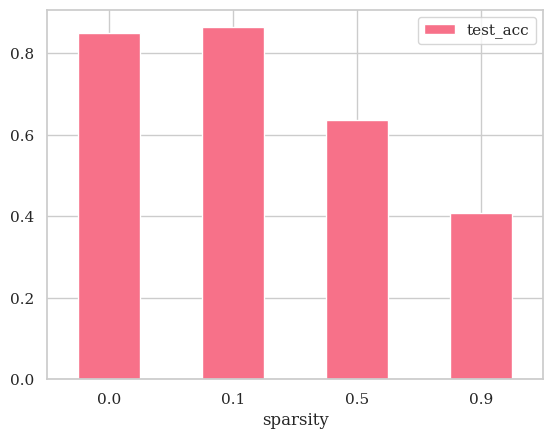

In [23]:
results_data_df.groupby("sparsity").mean().plot.bar(y="test_acc", rot=0)

In [ ]:
# Pruning [0, 0.1, 0.5, 0.9]
# 1. Load the best model
# 2. Loop through its layers
# 3. At each layer, set a random % of weights to zero (% sparsity)
# 4. Test